**Loading the dataset using Kaggle API**

In [1]:
#!pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d hassan06/nslkdd

In [2]:
!unzip nslkdd.zip

Archive:  nslkdd.zip
  inflating: KDDTest+.arff           
  inflating: KDDTest+.txt            
  inflating: KDDTest-21.arff         
  inflating: KDDTest-21.txt          
  inflating: KDDTest1.jpg            
  inflating: KDDTrain+.arff          
  inflating: KDDTrain+.txt           
  inflating: KDDTrain+_20Percent.arff  
  inflating: KDDTrain+_20Percent.txt  
  inflating: KDDTrain1.jpg           
  inflating: index.html              
  inflating: nsl-kdd/KDDTest+.arff   
  inflating: nsl-kdd/KDDTest+.txt    
  inflating: nsl-kdd/KDDTest-21.arff  
  inflating: nsl-kdd/KDDTest-21.txt  
  inflating: nsl-kdd/KDDTest1.jpg    
  inflating: nsl-kdd/KDDTrain+.arff  
  inflating: nsl-kdd/KDDTrain+.txt   
  inflating: nsl-kdd/KDDTrain+_20Percent.arff  
  inflating: nsl-kdd/KDDTrain+_20Percent.txt  
  inflating: nsl-kdd/KDDTrain1.jpg   
  inflating: nsl-kdd/index.html      


**Importing modules**

In [30]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
import plotly.express as px
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

**Loading dataset**

In [31]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent'
            ,'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root'
            ,'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login'
            ,'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
            ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
            ,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate'
            ,'dst_host_srv_rerror_rate','attack','outcome'])

In [32]:
df = pd.read_csv('KDDTrain+.txt',names = columns)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,outcome
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


**Checking for null values**

In [33]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

**Dropping outcome column**

In [34]:
df = df.drop(columns='outcome',axis=1)

**Exploratory Data Analysis**

**Normal means there is no attack and other than that is attack**

In [35]:
attack_n = []
for i in df.attack :
  if i == 'normal':
    attack_n.append("normal")
  else:
    attack_n.append("attack")
df['attack'] = attack_n 

In [36]:
value_counts = df.attack.value_counts()
value_counts

normal    67343
attack    58630
Name: attack, dtype: int64

In [37]:
fig = px.bar(df, y=[value_counts[0],value_counts[1]],x=['Normal','Attack'], text_auto='.2s', title="Normal vs Attack")
fig.show()

<AxesSubplot:xlabel='protocol_type', ylabel='count'>

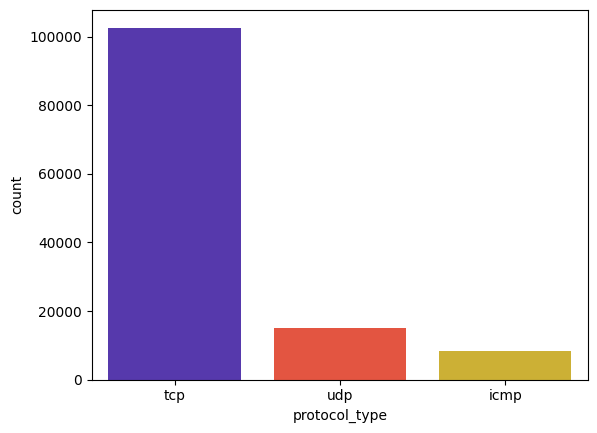

In [38]:
sns.countplot(x='protocol_type',data=df, palette ='CMRmap')

<AxesSubplot:xlabel='protocol_type', ylabel='count'>

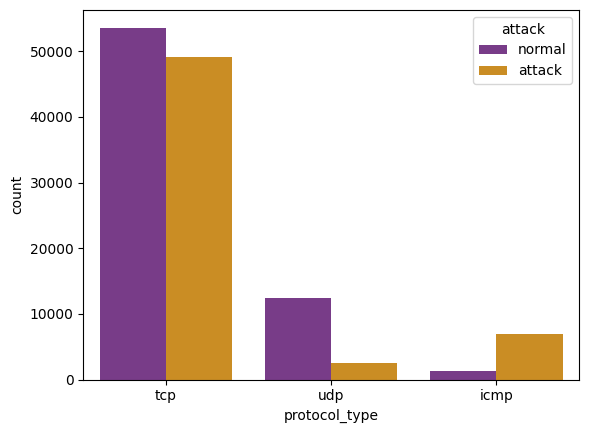

In [39]:
sns.countplot(x='protocol_type',hue='attack' , data = df , palette ='CMRmap')

**Doing Label Encoding on object type**

In [40]:
data_obj = df.select_dtypes(['object']).columns

In [41]:
data_obj

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')

In [42]:
from sklearn.preprocessing import LabelEncoder
protocol_type_le = LabelEncoder()
service_le = LabelEncoder()
flag_le = LabelEncoder()
# attack_le = LabelEncoder()

In [43]:
df['protocol_type'] = protocol_type_le.fit_transform(df['protocol_type'])
df['service'] = service_le.fit_transform(df['service'])
df['flag'] = flag_le.fit_transform(df['flag'])
df['attack'] = df['attack'].map({'attack':1,'normal':0})

In [44]:
print(df.protocol_type.value_counts(),end="\n\n--------------------------\n")
print(df.service.value_counts(),end="\n\n--------------------------\n")
print(df.flag.value_counts(),end="\n\n--------------------------\n")
print(df.attack.value_counts())

1    102689
2     14993
0      8291
Name: protocol_type, dtype: int64

--------------------------
24    40338
49    21853
12     9043
54     7313
20     6860
      ...  
61        3
27        2
3         2
22        2
25        1
Name: service, Length: 70, dtype: int64

--------------------------
9     74945
5     34851
1     11233
4      2421
2      1562
6       365
10      271
7       127
3       103
8        49
0        46
Name: flag, dtype: int64

--------------------------
0    67343
1    58630
Name: attack, dtype: int64


**Correlation table**

In [17]:
fig = px.imshow(df.corr(),text_auto=True)
fig.show()

**Showing top 15 correlated values**

In [45]:
top_15_label = abs(df.corr()['attack']).sort_values()[-17:-1]
top_15_label

dst_host_srv_rerror_rate    0.253430
srv_rerror_rate             0.253504
service                     0.276548
protocol_type               0.281355
dst_host_count              0.375052
count                       0.576444
flag                        0.647073
srv_serror_rate             0.648289
serror_rate                 0.650652
dst_host_serror_rate        0.651842
dst_host_srv_serror_rate    0.654985
logged_in                   0.690171
dst_host_same_srv_rate      0.693803
dst_host_srv_count          0.722535
same_srv_rate               0.751913
attack                      1.000000
Name: attack, dtype: float64

**Training model with this 15 highly coorelated values**

In [46]:
columns = top_15_label.index

**Using stratified cross validation for model training to avoid chances of overfitting**

In [47]:
class config:
    NUM_FOLDS = 5
    SEED = 541
    TARGET = 'attack'
    JUNK = -1

def create_folds(data):    
    data["kfold"] = -1

    kf = model_selection.StratifiedKFold(n_splits=config.NUM_FOLDS, shuffle=True, random_state=config.SEED)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data[config.TARGET].values)):
        data.loc[v_, 'kfold'] = f    
    
    return data

In [20]:
def retrieve_data(train_folds,fold):


  train_data = train_folds[train_folds['kfold'] != fold].reset_index(drop=True)
  valid_data = train_folds[train_folds['kfold'] == fold].reset_index(drop=True)

  x_train = train_data.drop(['kfold', config.TARGET], axis=1)
  cols = x_train.columns
  x_train = x_train.values
  y_train = train_data[config.TARGET].values
      
  x_valid = valid_data.drop(['kfold', config.TARGET], axis=1).values
  y_valid = valid_data[config.TARGET].values


  return x_train,x_valid,y_train,y_valid

In [48]:
train1 = df[columns]
display(train1.head())
train_folds = create_folds(train1)

,dst_host_srv_rerror_rate,srv_rerror_rate,service,protocol_type,dst_host_count,count,flag,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,logged_in,dst_host_same_srv_rate,dst_host_srv_count,same_srv_rate,attack
0,0.00,0.0,20,1,150,2,9,0.0,0.0,0.00,0.00,0,0.17,25,1.00,0
1,0.00,0.0,44,2,255,13,9,0.0,0.0,0.00,0.00,0,0.00,1,0.08,0
2,0.00,0.0,49,1,255,123,5,1.0,1.0,1.00,1.00,0,0.10,26,0.05,1
3,0.01,0.0,24,1,30,5,9,0.2,0.2,0.03,0.01,1,1.00,255,1.00,0
4,0.00,0.0,24,1,255,30,9,0.0,0.0,0.00,0.00,1,1.00,255,1.00,0


C:\Users\yerpu\AppData\Local\Temp\ipykernel_1332\2454635029.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()

**Logistic Regression**

In [50]:
max = 0
lr_dummy = None
for fold in range(config.NUM_FOLDS):
  
  x_train,x_valid,y_train,y_valid = retrieve_data(train_folds,fold)
  x_train = scalar.fit_transform(x_train)
  x_valid = scalar.fit_transform(x_valid)
  lr = LogisticRegression(max_iter=1000)

  lr.fit(x_train, y_train)


  y_pred_train = lr.predict(x_train)  #np.where(yhat_train[:,1] >= best_thresh,1,0)
  y_pred_test = lr.predict(x_valid) #np.where(yhat_test[:,1] >= best_thresh,1,0)
  
  if(accuracy_score(y_valid,y_pred_test) > max):
    max = accuracy_score(y_valid,y_pred_test)
    lr_dummy = lr


  print("Training accuracy : ",accuracy_score(y_train,y_pred_train))
  print("Testing accuracy : ",accuracy_score(y_valid,y_pred_test))
  # #print("F1_Score : ",f1_score(y_valid, y_pred_test))
  # print("Precision score : ",precision_score(y_valid, y_pred_test))
  # print("Recall score : ",recall_score(y_valid, y_pred_test))
  print(classification_report(y_valid, y_pred_test))
  print(confusion_matrix(y_valid, y_pred_test))

  print("\n\n-----------------------------------------------------------------------",end="\n\n")

Training accuracy :  0.9373772053424358
Testing accuracy :  0.9357809089104981
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     13469
           1       0.95      0.91      0.93     11726

    accuracy                           0.94     25195
   macro avg       0.94      0.93      0.94     25195
weighted avg       0.94      0.94      0.94     25195

[[12921   548]
 [ 1070 10656]]


-----------------------------------------------------------------------

Training accuracy :  0.9366329952965925
Testing accuracy :  0.9360190513990871
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     13469
           1       0.95      0.91      0.93     11726

    accuracy                           0.94     25195
   macro avg       0.94      0.93      0.94     25195
weighted avg       0.94      0.94      0.94     25195

[[12943   526]
 [ 1086 10640]]


-------------------------------------------------

**Saving the model**

In [51]:
import pickle
filename = 'lr_model.pkl'
pickle.dump(lr_dummy, open(filename, 'wb'))

**Decision Tree**

In [55]:
max = 0
dt_dummy = None
for fold in range(config.NUM_FOLDS):
  
  x_train,x_valid,y_train,y_valid = retrieve_data(train_folds,fold)
  dt = DecisionTreeClassifier(max_depth=11)

  dt.fit(x_train, y_train)
  print(x_train.shape)
  print(x_valid.shape)


  y_pred_train = dt.predict(x_train)  #np.where(yhat_train[:,1] >= best_thresh,1,0)
  y_pred_test = dt.predict(x_valid) #np.where(yhat_test[:,1] >= best_thresh,1,0)
  
  if(accuracy_score(y_valid,y_pred_test) > max):
    max = accuracy_score(y_valid,y_pred_test)
    dt_dummy = dt


  print("Training accuracy : ",accuracy_score(y_train,y_pred_train))
  print("Testing accuracy : ",accuracy_score(y_valid,y_pred_test))
  print(classification_report(y_valid, y_pred_test))
  print(confusion_matrix(y_valid, y_pred_test))

  print("\n\n-----------------------------------------------------------------------",end="\n\n")

(100778, 15)
(25195, 15)
Training accuracy :  0.9904939570144278
Testing accuracy :  0.9879738043262553
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     13469
           1       0.99      0.98      0.99     11726

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195

[[13379    90]
 [  213 11513]]


-----------------------------------------------------------------------

(100778, 15)
(25195, 15)
Training accuracy :  0.9929945027684614
Testing accuracy :  0.991387179996031
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13469
           1       0.99      0.99      0.99     11726

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195

[[13402    67]
 [  150 11576]]




In [53]:
filename = 'dt_model.pkl'
pickle.dump(dt_dummy, open(filename, 'wb'))

**Random Forest**

In [54]:
max = 0
rf_dummy = None
for fold in range(config.NUM_FOLDS):
  
  x_train,x_valid,y_train,y_valid = retrieve_data(train_folds,fold)
  rf = RandomForestClassifier(n_estimators=400,max_depth=11)

  rf.fit(x_train, y_train)


  y_pred_train = rf.predict(x_train)  #np.where(yhat_train[:,1] >= best_thresh,1,0)
  y_pred_test = rf.predict(x_valid) #np.where(yhat_test[:,1] >= best_thresh,1,0)
  
  if(accuracy_score(y_valid,y_pred_test) > max):
    max = accuracy_score(y_valid,y_pred_test)
    rf_dummy = rf


  print("Training accuracy : ",accuracy_score(y_train,y_pred_train))
  print("Testing accuracy : ",accuracy_score(y_valid,y_pred_test))
  print(classification_report(y_valid, y_pred_test))
  print(confusion_matrix(y_valid, y_pred_test))

  print("\n\n-----------------------------------------------------------------------",end="\n\n")

Training accuracy :  0.9907321042290976
Testing accuracy :  0.9898789442349673
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13469
           1       1.00      0.98      0.99     11726

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195

[[13434    35]
 [  220 11506]]


-----------------------------------------------------------------------

Training accuracy :  0.9916648474865546
Testing accuracy :  0.9902758483826156
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13469
           1       1.00      0.98      0.99     11726

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195

[[13439    30]
 [  215 11511]]


-------------------------------------------------

In [28]:
filename = 'rf_model.pkl'
pickle.dump(rf_dummy, open(filename, 'wb'))

**printing unique values**

In [56]:
for i in columns:
  print(i,sep="\t",end="\n\n")
  print(df[i].unique(),end="\n\n")

dst_host_srv_rerror_rate

[0.   0.01 1.   0.16 0.57 0.61 0.68 0.96 0.88 0.84 0.91 0.12 0.79 0.02
 0.04 0.29 0.03 0.99 0.97 0.07 0.75 0.2  0.44 0.08 0.06 0.81 0.32 0.55
 0.33 0.5  0.05 0.15 0.45 0.66 0.93 0.89 0.62 0.67 0.27 0.41 0.98 0.71
 0.38 0.74 0.19 0.39 0.11 0.92 0.7  0.72 0.73 0.9  0.17 0.53 0.87 0.69
 0.77 0.78 0.52 0.35 0.34 0.13 0.28 0.95 0.47 0.31 0.86 0.65 0.82 0.94
 0.64 0.26 0.14 0.6  0.22 0.4  0.1  0.25 0.09 0.18 0.54 0.21 0.59 0.85
 0.8  0.37 0.49 0.56 0.76 0.51 0.24 0.48 0.83 0.36 0.58 0.3  0.42 0.63
 0.43 0.46 0.23]

srv_rerror_rate

[0.   1.   0.03 0.1  0.2  0.25 0.08 0.11 0.33 0.43 0.5  0.07 0.14 0.62
 0.09 0.81 0.06 0.17 0.05 0.75 0.8  0.29 0.12 0.04 0.02 0.71 0.79 0.83
 0.56 0.67 0.84 0.4  0.64 0.74 0.38 0.85 0.15 0.69 0.6  0.73 0.76 0.57
 0.86 0.92 0.82 0.18 0.22 0.78 0.77 0.88 0.96 0.7  0.9  0.72 0.01 0.89
 0.55 0.87 0.95 0.13 0.58 0.3 ]

service

[20 44 49 24 51 36 38 14 35 60 18 12 58 67  2 54  7 66 37 65  4 11 19  5
 32 15 21 68 59 26 16 69 28 29 13 30 33 57 